In [1]:
import tensorflow as tf
import os
import cv2
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import imageio

C:\Users\user\anaconda3\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import gdown ## to download public data from Google drive

### 1. Data Collection and Pre-Processing

In [3]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
# giving all the letters and numbers as vocab

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

# char_to_num converts characters to numeric indices using a given vocabulary (vocab).
# num_to_char converts numeric indices back to the corresponding characters, using the inverted vocabulary from char_to_num.
# This is useful for text encoding (character-level or word-level tokenization) and decoding (converting back to original text).

# the oov_token argument is used to specify a token for "out-of-vocabulary" (OOV) words (or characters). If an input string is not found in the vocab, 
# it will be replaced by this special token. In this case, the oov_token is set to an empty string (""), meaning that OOV inputs are replaced by "".

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [7]:
char_to_num(['r','a','y','y','a','n'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([18,  1, 25, 25,  1, 14], dtype=int64)>

In [8]:
num_to_char([18,  1, 25, 25,  1, 14])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'r', b'a', b'y', b'y', b'a', b'n'], dtype=object)>

In [9]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [10]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [11]:
test_path = '.\\data\\s1\\bbaf4p.mpg'

In [12]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]


'bbaf4p'

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


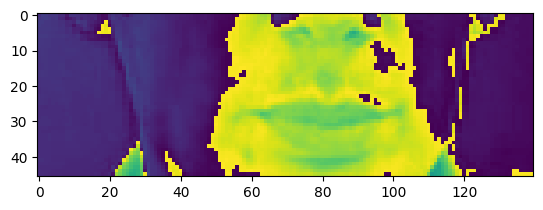

In [14]:
plt.imshow(frames[40]) ## showing 41th frame of test_path video
plt.show()

### 2. Building data pipeline

In [15]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [16]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg') ## reading all the video file 
data = data.shuffle(500, reshuffle_each_iteration=False) # shuffling the data
data = data.map(mappable_function) ## mapping the data and process each video one by one
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # batching up the data into 2 videos and 2 alignment batches and 75 frames in video
data = data.prefetch(tf.data.AUTOTUNE)
# The prefetch transformation allows the pipeline to fetch (or prepare) data for the next training step while the current step is being executed. 
# It overlaps data preprocessing and model execution to reduce idle time and improve performance.
train = data.take(450)
test = data.skip(450)


In [17]:
# Added for split 
train = data.take(450)
test = data.skip(450)

In [18]:
frames, alignments = data.as_numpy_iterator().next()


In [19]:
len(frames)

2

In [20]:
sample = data.as_numpy_iterator()

In [21]:
val = sample.next(); val[0]


array([[[[[ 1.39015   ],
          [ 1.39015   ],
          [ 1.39015   ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.39015   ],
          [ 1.39015   ],
          [ 1.39015   ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.39015   ],
          [ 1.39015   ],
          [ 1.39015   ],
          ...,
          [10.426125  ],
          [10.426125  ],
          [10.426125  ]],

         ...,

         [[ 0.8995088 ],
          [ 0.8995088 ],
          [ 0.8995088 ],
          ...,
          [10.139916  ],
          [10.180803  ],
          [10.180803  ]],

         [[ 0.8995088 ],
          [ 0.8995088 ],
          [ 0.8995088 ],
          ...,
          [10.0990305 ],
          [10.139916  ],
          [10.139916  ]],

         [[ 0.8995088 ],
          [ 0.8995088 ],
          [ 0.8995088 ],
          ...,
          [10.0990305 ],
          [10.139916  ],
          

In [22]:
if isinstance(val, tuple):
    val = val[0]

# Normalize and convert to uint8 (scaling values from [0, 1] to [0, 255])
frames = (val * 255).astype(np.uint8)

# Save all frames as an animated GIF


In [23]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [24]:
val = sample.next()

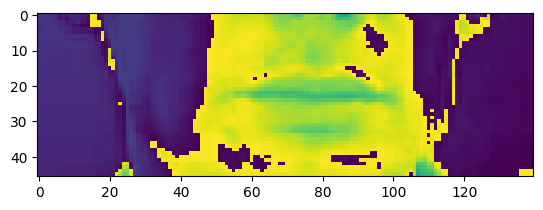

In [25]:
plt.imshow(val[0][0][0]) # 1st 0:videos, 2nd 0: 1st video out of the batch,  3rd 0: return the first frame in the video 
plt.show()

## Building model

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, Dense,LSTM, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [30]:
yhat = model.predict(val[0])


1/1 [==============================] - 4s 4s/step


In [31]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'ww66nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnxxxxxnnnnnnnnnnnnnnnnnnnnqqqqqq'>

In [32]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'ww66nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnxxxxxnnnnnnnnnnnnnnnnnnnnqqqqqq'>

In [33]:
model.input_shape


(None, 75, 46, 140, 1)

In [34]:
model.output_shape


(None, 75, 41)

In [35]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [36]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [37]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CTCLoss)


In [39]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [40]:
schedule_callback = LearningRateScheduler(scheduler)


In [41]:
example_callback = ProduceExample(test)


In [42]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


In [43]:
model.load_weights('models/checkpoint')

In [44]:
test_data = test.as_numpy_iterator()

In [45]:
sample = test_data.next()

In [46]:
yhat = model.predict(sample[0])

1/1 [==============================] - 6s 6s/step


In [47]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red with z three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red by i zero please'>]

In [48]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [49]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red with r three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red by i zero please'>]

In [56]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbbm2p.mpg'))


In [57]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by m two please'>]

In [58]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [59]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [60]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by m two please'>]

In [61]:
model.save("models/lipnet_model2.h5") 
